# <br> Up your ML game 
![title](images/levelup.jpg)
## PyHEP  
### Liv Våge 28.10.2025 

# Why this talk?

The ML ecosystem changes **fast**. 

E.g. by the time you finally understand the intricacies of one package it falls out of favour (_tensorflow_ 👀)

**Goal:** Help you pick the right tools, increase efficiency and smooth out pain points 

**Disclaimer:** If you're well versed in ML, there might not be a lot of new material here. And these are just my biased opinions -
please make a PR with edits if you find mistakes or have something to add! 

---

## What we'll cover:
1. **ML Frameworks** - PyTorch, JAX, Keras, etc. (which one and why?)
2. **Workflow Tools** - W&B, MLflow, Optuna (making it trackable and reproducable)
3. **Training & Deployment** - ONNX, HTCondor, hls4ml (scale it up)
4. **HEP-ML Bridge** - uproot, awkward, hist (one of the major pain points)
5. **Industry Tools** - What industry does better (and what we can steal)
6. **Fun Shortcuts** - LLMs, Hugging Face, and other "cheats"


# 1. Common ML Frameworks



## Which framework should I use?

**Short answer:** PyTorch (probably)

**Long answer:** Depends on the use case 

### Quick Framework Comparison

| Framework | Best For | Pros | Cons |
|-----------|----------|------|------|
| **PyTorch** | Research, flexibility, HEP | Pythonic, great debugging, huge community | Verbose, more boilerplate |
| **PyTorch Lightning** | Production, clean code | Organized, less boilerplate, built-in best practices | Another abstraction to learn |
| **JAX** | Speed demons, researchers | FAST, functional programming, auto-vectorization | functional paradigm learning curve |
| **Keras** | Beginners, quick prototypes | Super simple API, fast to start | Less flexibility, slower development |
| **Scikit-learn** | Classical ML, baselines | Easy, stable, great docs | Not for deep learning |
| **XGBoost** | Tabular data, structured features | Fast, interpretable, great for HEP kinematics | Not for complex deep learning |
| **Tensorflow** | Legacy code | You might find legacy code examples in tensorflow | It's falling out of favour, would avoid if possible|

_Note that Keras is actually an API that lets you call jax, tensorflow and pytorch!_ 

- Just starting? → **Keras** or **Scikit-learn**
- Need a quick baseline on tabular data? → **XGBoost** or **Scikit-learn**
- Working with HEP kinematic features? → **XGBoost** (often best!)
- Doing research/custom architectures? → **PyTorch**
- Want cleaner code? → **PyTorch Lightning**
- Need maximum speed? → **JAX**
- Working in a team? → **PyTorch** or **PyTorch Lightning**
- You can also write custom Cuda code if you really like to suffer


### 1.1 - XGBoost: The Gradient Boosting Powerhouse

**What it is:** Extreme Gradient Boosting - tree-based ensemble method

**Why it matters for HEP:**
- Handles tabular data exceptionally well (which HEP has lots of!)
- Often outperforms neural networks on structured data
- Interpretable (feature importance, SHAP values)
- Fast training and inference
- Great baseline before trying deep learning

**When to use:**
- Tabular data with many features
- Need quick, interpretable results
- Want feature importance
- Limited training data available


In [5]:
# Quick demo: Same simple neural network in different frameworks
import numpy as np

# Generate some fake HEP-like data (4 kinematic features)
np.random.seed(42)
X_train = np.random.randn(1000, 4).astype(np.float32)
y_train = (X_train[:, 0] + X_train[:, 1] > 0).astype(np.float32)
X_test = np.random.randn(200, 4).astype(np.float32)
y_test = (X_test[:, 0] + X_test[:, 1] > 0).astype(np.float32)

print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")


Training data: (1000, 4), Labels: (1000,)


In [37]:
# XGBoost example

import xgboost as xgb
from sklearn.metrics import accuracy_score

# Train XGBoost
clf_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0)
clf_xgb.fit(X_train, y_train)

# Evaluate
y_pred_xgb = clf_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

# Show feature importance
print("Feature Importance:")
for i, imp in enumerate(clf_xgb.feature_importances_):
    print(f"  Feature {i}: {imp:.3f}")

XGBoost Accuracy: 0.980
Feature Importance:
  Feature 0: 0.509
  Feature 1: 0.462
  Feature 2: 0.015
  Feature 3: 0.015


## 1.2 - Scikit learn

Great for a range of ML models and quick benchmarking 

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

# Match the same hyperparameters as other neural networks
start_sklearn = time.time()
clf = MLPClassifier(hidden_layer_sizes=(4, 16, 1), max_iter=20, random_state=42,
                    learning_rate='constant', learning_rate_init=0.001,
                    solver='adam', activation='tanh', batch_size=32)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
time_sklearn = time.time() - start_sklearn
print(f"✅ Scikit-learn: 3 lines and done. Accuracy: {acc:.3f}")



✅ Scikit-learn: 3 lines and done. Accuracy: 0.995


/Users/liv/pyhep-talk/venv-pyhep/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


A very neat detail is that in most libraries (xgboost, sklearn, pytorch, keras) follow the same general pattern of 
```
model = ...
model.fit(data)
model.predict(data)
``` 

## 1.3 - Neural networks 

#### Option 1: PyTorch (the verbose way)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define PyTorch model class
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Standard architecture: 4 -> 16 -> 1
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

print("✅ PyTorch model defined")


✅ PyTorch model defined


In [33]:
import time
from sklearn.metrics import accuracy_score

# PyTorch training with exact same hyperparameters
start_pytorch = time.time()
torch.manual_seed(42)
model_torch = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

model_torch.train()
for epoch in range(20):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_torch(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

model_torch.eval()
with torch.no_grad():
    predictions = (model_torch(torch.from_numpy(X_test).float()).numpy().flatten() > 0.5).astype(int)
    acc_pytorch = accuracy_score(y_test, predictions)

time_pytorch = time.time() - start_pytorch
print(f"✅ PyTorch: Full control. Accuracy: {acc_pytorch:.3f}")



✅ PyTorch: Full control. Accuracy: 0.980


#### Option 2: PyTorch Lightning (the clean and quick code way)


Pytorch lightning relies on inheritance so you don't have to write boilerplate code. It's great for development, but is generally disfavoured in production - you only need inference and other libraries handle that better. 

In [34]:
import pytorch_lightning as pl

class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)  # Match other frameworks
        self.layers = nn.Sequential(
            nn.Linear(4, 16), nn.Tanh(), nn.Linear(16, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.BCELoss()(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

print("✅ PyTorch Lightning model class defined")


✅ PyTorch Lightning model class defined


In [35]:
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
import time

# PyTorch Lightning training
start_pl = time.time()
torch.manual_seed(42)
lit_model = LitModel()
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader_pl = DataLoader(train_dataset, batch_size=32, shuffle=False)
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=1000, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False, fast_dev_run=False)
trainer.fit(lit_model, train_loader_pl)

# Faster evaluation - use the underlying PyTorch model directly
lit_model.eval()
X_test_t = torch.from_numpy(X_test).float()
with torch.no_grad():
    outputs = lit_model(X_test_t)
    predictions_pl = (outputs.squeeze().numpy() > 0.5).astype(int)
    acc_pl = accuracy_score(y_test, predictions_pl)

time_pl = time.time() - start_pl
print(f"✅ PyTorch Lightning: Clean code. Accuracy: {acc_pl:.3f}")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liv/pyhep-talk/venv-pyhep/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=20` reached.


✅ PyTorch Lightning: Clean code. Accuracy: 0.980


#### Option 3: Keras (the simple API way)


In [20]:
# Keras: Super simple API
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import time
# Set random seed for reproducibility
start_keras = time.time()
tf.random.set_seed(42)
# Define and compile model - matches PyTorch architecture
model_keras = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=(4,)),
    layers.Dense(1, activation='sigmoid')
])
model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy')
# Train
model_keras.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
# Evaluate
y_pred_keras = (model_keras.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
acc_keras = accuracy_score(y_test, y_pred_keras)
time_keras = time.time() - start_keras
print(f"✅ Keras: 4 lines of code. Accuracy: {acc_keras:.3f}")


/Users/liv/pyhep-talk/venv-pyhep/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Keras: 4 lines of code. Accuracy: 0.990


#### Option 4: JAX (the functional way)

In [21]:
# JAX: Functional programming approach
import jax
import jax.numpy as jnp
from jax import random
import optax
from sklearn.metrics import accuracy_score
import numpy as np
import time
# Set seed for reproducibility
start_jax = time.time()
key = random.PRNGKey(42)
np.random.seed(42)
# Initialize parameters - same architecture as others
layer_sizes = [4, 16, 1]
keys = random.split(key, len(layer_sizes))
params = []
for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
    w_key, b_key = random.split(k)
    w = random.normal(w_key, (m, n)) * 0.1
    b = random.normal(b_key, (n,)) * 0.1
    params.append((w, b))
# Forward pass
def forward(params, x):
    for w, b in params[:-1]:
        x = jnp.tanh(x @ w + b)
    w, b = params[-1]
    return jax.nn.sigmoid(x @ w + b).squeeze()
# Loss function
def loss_fn(params, x, y):
    pred = forward(params, x)
    return optax.sigmoid_binary_cross_entropy(pred, y).mean()
# Training
optimizer_jax = optax.adam(learning_rate=0.001)
opt_state = optimizer_jax.init(params)
X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)
X_test_jax = jnp.array(X_test)
y_test_jax = jnp.array(y_test)
batch_size = 32
n_batches = len(X_train) // batch_size
for epoch in range(20):
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_train_jax[start_idx:end_idx]
        y_batch = y_train_jax[start_idx:end_idx]
        loss, grads = jax.value_and_grad(loss_fn)(params, X_batch, y_batch)
        updates, opt_state = optimizer_jax.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
# Evaluate
test_pred = forward(params, X_test_jax) > 0.5
acc_jax = accuracy_score(y_test, np.array(test_pred))
time_jax = time.time() - start_jax
print(f"✅ JAX: Functional and fast. Accuracy: {acc_jax:.3f}")


✅ JAX: Functional and fast. Accuracy: 0.960


In [28]:
# Comparison: Timing and Accuracy

import pandas as pd

print("="*60)
print("FRAMEWORK COMPARISON")
print("="*60)
print("All neural networks use identical setup:")

print("- Architecture: 4→16→1 (tanh activation)")
print("- Optimizer: Adam (lr=0.001)")
print("- Training: 20 epochs, batch_size=32")
print("- Random seed: 42")
print("="*60)

# Compare the results from individual training cells above
print()
print("Results:")
print("-" * 60)
print(f"Scikit-learn:  Accuracy: {acc:.3f},  Time: {time_sklearn:.3f}s")
print(f"PyTorch:       Accuracy: {acc_pytorch:.3f},  Time: {time_pytorch:.3f}s")
print(f"PyTorch L.:    Accuracy: {acc_pl:.3f},  Time: {time_pl:.3f}s")
print(f"Keras:         Accuracy: {acc_keras:.3f},  Time: {time_keras:.3f}s")
print(f"JAX:           Accuracy: {acc_jax:.3f},  Time: {time_jax:.3f}s")
print("-" * 60)

print()
print("✅ All frameworks achieved similar accuracy (~0.98)")
print("💡 PyTorch Lightning is slower due to framework overhead")
print("💡 Pick based on ease of use, not performance differences!")

FRAMEWORK COMPARISON
All neural networks use identical setup:
- Architecture: 4→16→1 (tanh activation)
- Optimizer: Adam (lr=0.001)
- Training: 20 epochs, batch_size=32
- Random seed: 42

Results:
------------------------------------------------------------
Scikit-learn:  Accuracy: 0.995,  Time: 0.525s
PyTorch:       Accuracy: 0.980,  Time: 0.522s
PyTorch L.:    Accuracy: 0.980,  Time: 2.343s
Keras:         Accuracy: 0.990,  Time: 1.539s
JAX:           Accuracy: 0.960,  Time: 5.259s
------------------------------------------------------------

✅ All frameworks achieved similar accuracy (~0.98)
💡 PyTorch Lightning is slower due to framework overhead
💡 Pick based on ease of use, not performance differences!


## Takeaway:

All neural networks above use **identical setup**: 
- Architecture: 4→16→1 (tanh activation)
- Optimizer: Adam (lr=0.001)
- Training: 20 epochs
- Batch size: 32
- Same random seed (42)

The comparison shows:
- **Accuracy should are very similar** across neural network frameworks (differences reflect implementation details and numerical precision)
- **Speed varies** due to different optimizations and backend implementations - also because this is a very small example 

**Bottom line:** Choose your framework based on ease of use and ecosystem, not tiny performance differences.



 # 2 - ML workflow tools 

Moving beyond jupyter notebooks and into configuration file centred and reproducible ML 

### 2.1 Logging experiments with Weights & Biases (W&B) 

**What it does:**
- Automatic logging of metrics, hyperparameters, system info
- Beautiful dashboards
- Experiment comparison
- Model versioning
- Artifact tracking
- **Free for academics!**

**When to use:** Any serious project. Very easy to set up


In [23]:
# W&B Quick Start - Experiment Monitoring

import wandb
#  # You need to create an account and log in the first time

# Initialize tracking
wandb.init(
    project="pyhep-demo", 
    name="neural-network-comparison2",
    config={
        "learning_rate": 0.01,
        "epochs": 20,
        "batch_size": 32,
        "architecture": "Scale→16→1"
    }
)

# Simulate training with fake metrics
for epoch in range(5):
    fake_loss = 1.0 / (epoch + 2) + 0.1
    fake_acc = 0.8 + epoch * 0.04
    wandb.log({
        "loss": fake_loss,
        "accuracy": fake_acc,
        "epoch": epoch
    })

wandb.finish()
print("🎨 W&B: Beautiful dashboards for experiment tracking")


/Users/liv/pyhep-talk/venv-pyhep/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/liv/pyhep-talk/venv-pyhep/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

accuracy,▁▃▅▆█
epoch,▁▃▅▆█
loss,█▄▃▂▁
accuracy,0.96
epoch,4
loss,0.26667


🎨 W&B: Beautiful dashboards for experiment tracking


### 2.2 MLflow - The Open Source Alternative

**Pros:**
- Fully open source
- Self-hosted (for the privacy-conscious)
- Experiment tracking + model registry
- Works with any ML library

**Cons:**
- Less pretty than W&B
- Need to host it yourself
- Smaller community

**When to use:** You need full control, can't/won't use cloud services


### Key Difference: W&B vs MLflow

**W&B (Weights & Biases):**
- **Best at:** Experiment monitoring, visualization, hyperparameter tuning
- Interactive dashboards, automatic logging
- Great for research and experimentation
- Cloud-first (free for academics)

**MLflow:**
-  **Best at:** Model registry, versioning, deployment, MLOps
-  Model storage and retrieval
-  Production deployment support
-  On-premise friendly

**TL;DR:** Use W&B for experiments, MLflow for production models.

### 2.3 Optuna - Hyperparameter Optimization Made Easy

**Going beyond grid searches**

Optuna uses smart algorithms (TPE, CMA-ES) to find good hyperparameters faster.


In [24]:
# Optuna example - hyperparameter tuning
import optuna

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    
    # For demo, return a mock score based on lr
    # In reality, you'd train a model with this lr and return validation score
    import random
    random.seed(int(lr * 1000))
    accuracy = random.uniform(0.85, 0.99)
    return accuracy

# Create and run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, show_progress_bar=False)

print(f"Best params: {study.best_params}")
print(f"Best value: {study.best_value:.3f}")

print("🎯 Optuna: Smarter than grid search, easier than manual tuning")
print("💡 Integrates with W&B, PyTorch Lightning, etc.")

[I 2025-10-28 12:18:32,793] A new study created in memory with name: no-name-bb00ee5b-599b-4719-ad6b-6b2957044bc5
[I 2025-10-28 12:18:32,805] Trial 0 finished with value: 0.8688109941757362 and parameters: {'lr': 0.0015138334581392512}. Best is trial 0 with value: 0.8688109941757362.
[I 2025-10-28 12:18:32,806] Trial 1 finished with value: 0.9682190592135067 and parameters: {'lr': 3.0483825644801777e-05}. Best is trial 1 with value: 0.9682190592135067.
[I 2025-10-28 12:18:32,807] Trial 2 finished with value: 0.8649559952782317 and parameters: {'lr': 0.014722167447595936}. Best is trial 1 with value: 0.9682190592135067.
[I 2025-10-28 12:18:32,809] Trial 3 finished with value: 0.9640269403626934 and parameters: {'lr': 0.07898903711912038}. Best is trial 1 with value: 0.9682190592135067.
[I 2025-10-28 12:18:32,809] Trial 4 finished with value: 0.9841493131744182 and parameters: {'lr': 0.02213876173293746}. Best is trial 4 with value: 0.9841493131744182.


Best params: {'lr': 0.02213876173293746}
Best value: 0.984
🎯 Optuna: Smarter than grid search, easier than manual tuning
💡 Integrates with W&B, PyTorch Lightning, etc.


### Combining W&B + Optuna: The Best of Both Worlds




In [25]:
# W&B + Optuna Integration

from optuna.integration.wandb import WeightsAndBiasesCallback
    
# Initialize W&B callback for Optuna
wandb_kwargs = {
    "project": "pyhep-optuna-demo",
    "job_type": "hyperparameter-optimization"
}
wandbc = WeightsAndBiasesCallback(metric_name="accuracy", wandb_kwargs=wandb_kwargs)

def objective(trial):
    # Optuna suggests hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # Mock training (in reality, train your model here)
    import random
    random.seed(int(lr * 1000))
    accuracy = random.uniform(0.85, 0.99)
    
    return accuracy

# Create study with W&B callback
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, callbacks=[wandbc], show_progress_bar=False)

print("✅ Optuna trials automatically logged to W&B!")
print(f"Best params: {study.best_params}")
print("\n📊 Check W&B dashboard: All trials with lr, batch_size, and accuracy")


/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_37954/1583329022.py:10: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="accuracy", wandb_kwargs=wandb_kwargs)


[I 2025-10-28 12:18:47,048] A new study created in memory with name: no-name-97826163-e908-4442-862b-54ce3d3ee275
[I 2025-10-28 12:18:47,056] Trial 0 finished with value: 0.9682190592135067 and parameters: {'lr': 0.00012622735517145287, 'batch_size': 64}. Best is trial 0 with value: 0.9682190592135067.
[I 2025-10-28 12:18:47,064] Trial 1 finished with value: 0.9682190592135067 and parameters: {'lr': 0.00045207508625450866, 'batch_size': 64}. Best is trial 0 with value: 0.9682190592135067.
[I 2025-10-28 12:18:47,072] Trial 2 finished with value: 0.8817388203133468 and parameters: {'lr': 0.008723512491819385, 'batch_size': 64}. Best is trial 0 with value: 0.9682190592135067.
[I 2025-10-28 12:18:47,077] Trial 3 finished with value: 0.9682190592135067 and parameters: {'lr': 0.00011168133878336508, 'batch_size': 16}. Best is trial 0 with value: 0.9682190592135067.
[I 2025-10-28 12:18:47,080] Trial 4 finished with value: 0.9682190592135067 and parameters: {'lr': 7.837733635031695e-05, 'batch

✅ Optuna trials automatically logged to W&B!
Best params: {'lr': 0.00012622735517145287, 'batch_size': 64}

📊 Check W&B dashboard: All trials with lr, batch_size, and accuracy


### 2.4 HEP-Specific ML Workflow Tools
<div>
<img src="images/b-hive-logo.png" height="50"/>
</div>

**b-hive** - CMS ML workflow tool 
- Codebase with links to documentation [here](https://gitlab.cern.ch/cms-btv/b-hive)
- Was initially created for jet tagging, is now being made more general 
- Main use is ML for root files, also integrates awkward and uproot 
- CMS internal tool (so far)
- Several similar tools in ATLAS, like salt, but they are more task specific, as far as I know 

<div>
<img src="images/law-logo.png" height="50"/>
</div>

**LAW** - A tool for workflow orchestration
- Documentation [here](https://law.readthedocs.io/en/latest/)
- Mainly used by CMS  
- Has abstractions for run locations and software environments 
- Integrates with e.g. HTCondor and CRAB 


**hep-ml-templates** - A new project for ML templating 
- Code [here](https://github.com/livaage/hep-ml-templates)
- Aim is to be able to install entire generalised ML workflows with one step 
- Pick and choose between a large amount of modules containing best practices 
- Can quick start new projects or improve old ones 
- Started as an IRIS-HEP summer project - is a work in progress


### 2.5 Industry workflow tools that we also use 

### Apache Airflow - Workflow Orchestration

**What it is:** Platform to programmatically author, schedule, and monitor workflows

**Pros:**
- Visual workflow DAGs (directed acyclic graphs)
- Scheduling and dependency management
- Great UI for monitoring tasks
- Python-based task definition
- Industry standard for data pipelines

**Cons:**
- Requires infrastructure setup
- Learning curve for DAG concepts
- Can be complex for simple workflows

**When to use:** You need to orchestrate complex data/ML pipelines with many steps


### Kubeflow - ML on Kubernetes

**What it is:** Kubernetes-native platform for ML workflows

**Pros:**
- Containerized ML pipelines
- Kubernetes orchestration (scale infinitely)
- Built-in experiment tracking
- Production-ready deployment
- Reproducible ML workflows

**Cons:**
- Needs Kubernetes expertise
- Infrastructure complexity
- Steep learning curve

**When to use:**
- You need production ML at scale
- Your org already uses Kubernetes
- You need advanced ML pipeline orchestration


### Workflow Tools: Quick Comparison

| Tool | Best For | Setup Difficulty | Cost |
|------|----------|------------------|------|
| **W&B** | Everything | Easy | Free (academic) |
| **MLflow** | On-premise, privacy | Medium | Free (self-host) |
| **Optuna** | Hyperparameter tuning | Easy | Free |
| **b-hive** | CERN users | Easy | Free (CERN) |
| **hep-ml-templates** | Quick project start | Easy | Free |
| **LAW** | CERN workflows | Medium | Free (CERN) |
| **Airflow** | Workflow orchestration | Hard | Free (self-host) |
| **Kubeflow** | ML on Kubernetes | Hard | Free (self-host) |

**Pro tip:** Use W&B + Optuna together. They integrate perfectly!
**For CERN users:** b-hive is built-in, lower setup barrier!
**For production:** Consider Airflow/Kubeflow if you need orchestration at scale


# 3. Model Training & Deployment

Get off your laptop!

Doing lots of ML locally is a quick way to burn through your hardware. 
The best option is usually a university cluster.

---

## 3.1 Tips for Working with a Grid System

####  Monitor Hardware Utilization

Always check if you're actually using the hardware efficiently:

**SLURM systems:**
```bash
# After your job completes or while it's running
jobstats <jobid>

# Or check GPU utilization in real-time (if connected to node)
nvidia-smi
```

**Pro tip:** If your GPU utilization is < 50%, you're probably not using the GPU effectively. Check for data loading bottlenecks!

### SSH Port Forwarding for Jupyter Notebooks

Even if your GPU cluster doesn't have wifi (they rarely do), you can still use Jupyter notebooks:

**Step 1: SSH into the cluster with port forwarding**
```bash
# Forward local port 8888 to remote port 8888
ssh -L 8888:localhost:8888 username@cluster.university.edu

# If you're behind a login node, double forward:
ssh -L 8888:compute-node:8888 username@login.cluster.edu
```

**Step 2: Start Jupyter on the cluster**
```bash
# After ssh'ing in, start jupyter
jupyter lab --no-browser --port=8888
# Or if you need a specific port:
jupyter lab --no-browser --port=8888 --ip=0.0.0.0
```

**Step 3: Access from your laptop**
- Open browser: `http://localhost:8888`
- Copy the token from the cluster terminal
- Paste it in the browser

**Pro tip:** Use `screen` or `tmux` to keep sessions alive if your SSH connection drops!

### SLURM Array Jobs for Hyperparameter Sweeps

Run multiple jobs with different configurations efficiently:

**Create a job script** (`train_job.sh`):
```bash
#!/bin/bash
#SBATCH --job-name=ml_train
#SBATCH --gres=gpu:1
#SBATCH --time=04:00:00
#SBATCH --mem=8G
#SBATCH --array=0-4

ARGS=(0.1 0.75 3 25.5 50)
# Activate your environment
source activate my_env

# Run training with config based on array task ID
python train.py --config configs/run_${SLURM_ARRAY_TASK_ID}.yaml
```

**Submit array job:**
```bash
# Submit 10 jobs with IDs 1-10
sbatch --array=1-10 train_job.sh

# Or specific indices
sbatch --array=1,3,5-10 train_job.sh
```

### Resource Management Best Practices

**Request appropriate resources:**
```bash
#SBATCH --gres=gpu:1          # One GPU is usually enough
#SBATCH --cpus-per-task=4     # Match your data loader workers
#SBATCH --mem=16G              # Request memory based on your batch size
```

**Use job dependencies for pipelines:**
```bash
# Submit data preprocessing job
job1=$(sbatch preprocess.sh | awk '{print $4}')

# Wait for it to complete, then train
job2=$(sbatch --dependency=afterok:$job1 train.sh | awk '{print $4}')

# Finally evaluate
sbatch --dependency=afterok:$job2 evaluate.sh
```

### Data Transfer Optimization

**Compress large datasets before transfer:**
```bash
# Cluster to local (compressed)
ssh username@cluster "tar -czf - data/" | tar -xzf - -C ./local_data/

# Or simpler: just use scp with compression
scp -C -r username@cluster:~/data/ ./local_data/

# Use rsync for incremental updates
rsync -avz --progress username@cluster:~/data/ ./local_data/
```

### Environment Management

**Create environment files that work across systems:**
```yaml
# environment.yml
channels:
  - pytorch
  - conda-forge
dependencies:
  - python=3.10
  - pytorch
  - numpy
  - pip
  - pip:
      - wandb
```

**Pro tip:** Use conda-pack to bundle your entire environment for easy transfer!

```bash
conda pack -n my_env -o my_env.tar.gz
# Transfer and unpack on target machine
tar -xzf my_env.tar.gz
source my_env/bin/activate
```


# 3.2 GPU Resources

**All major HEP institutions provide GPU resources!**

See detailed documentation: [CMS ML GPU Resources](https://cms-ml.github.io/documentation/Resources/GPU_Resources/index.html)

### GPU Resources at CERN 


Here's a comparison of GPU resources available at CERN (more details in the [CMS ML documentation](https://cms-ml.github.io/documentation/Resources/GPU_Resources/index.html)):

| Resource | Access Level | Best For | Notes |
|----------|--------------|----------|-------|
| **SWAN** | CERN users | Quick prototyping, teaching | Web-based Jupyter, lxplus integration, pre-configured |
| **lxplus-gpu.cern.ch** | CERN users | Interactive sessions | Direct GPU access, login node with GPUs |
| **HTCondor** | CERN users | Large-scale training | Batch jobs, array submissions, queue system |
| **ml.cern.ch** | CMS collaboration | Production ML | Dedicated ML infrastructure |

HTCondor is the only one where you can get more than 1 GPU without asking 


**Quick tips:**
- Start with **SWAN** for experimentation (easiest setup)
- Use **lxplus-gpu** for interactive debugging
- Submit **HTCondor** jobs for long training runs
- Access **ml.cern.ch** for production workloads

**Similar resources exist at other HEP institutions** - check with your local computing team!


## 3.3 ONNX - Make your model portable

**Problem:** Trained in PyTorch, but production uses TensorFlow (or C++, or...)

**Solution:** ONNX (Open Neural Network Exchange)

**What it does:**
- Convert models between frameworks
- Optimize for inference
- Deploy anywhere (edge devices, web, etc.)


In [ ]:
# ONNX Example - Export PyTorch model
import torch.onnx

# Create dummy input
dummy_input = torch.randn(1, 4)

# Export to ONNX
torch.onnx.export(model_torch, dummy_input, "model.onnx", verbose=False)

# Load and test with ONNX Runtime
import onnxruntime as ort
session = ort.InferenceSession("model.onnx")

# Test inference
test_input = X_test[:1].astype('float32')
ort_inputs = {session.get_inputs()[0].name: test_input}
result = session.run(None, ort_inputs)

print("📦 ONNX: Model exported and loaded successfully!")
print(f"Original prediction: {model_torch(torch.from_numpy(X_train[:1]).float()).item():.3f}")
print(f"ONNX prediction: {result[0][0][0]:.3f}")

print("\n ONNX: Train anywhere, deploy everywhere")
print("Especially useful for edge deployment and production")


W1028 10:42:57.146000 28037 torch/onnx/_internal/exporter/_registration.py:107] torchvision is not installed. Skipping torchvision::nms


📦 ONNX: Model exported and loaded successfully!
Original prediction: 0.500
ONNX prediction: 0.553

 ONNX: Train anywhere, deploy everywhere
Especially useful for edge deployment and production


### 3.4 Sonic (NVIDIA Triton) - Production Inference Server

**Problem:** You've trained a great model, now you need to serve it efficiently at scale

**Solution:** [Sonic](https://fastmachinelearning.org/SuperSONIC/) - CERN's adaptation of NVIDIA Triton Inference Server

**What it does:**
- High-performance inference serving
- Dynamic batching for throughput optimization
- Multi-model concurrent inference
- GPU acceleration with automatic batching
- Model versioning and A/B testing
- Easy integration with HEP analysis workflows

**Key features for HEP:**
- Handles multiple ONNX models efficiently
- Optimized for batch inference (perfect for ROOT file processing)
- Built for production CMS workflows
- REST and gRPC APIs

**When to use:**
- Production inference at scale
- Need concurrent model serving
- Want dynamic batching optimization
- Integrating ML into reconstruction/analysis pipelines

**Similar to:** NVIDIA Triton (industry standard), TensorRT Inference Server

**Pro tip:** Convert models to ONNX format, then serve with Sonic for optimal performance!


### 3.5 hls4ml - ML on FPGAs

**When you really need speed**

**Problem:** You need ultra-low latency inference (< 1 microsecond) for triggers

**Solution:** hls4ml converts your neural network to FPGA firmware

**Use cases:**
- LHC trigger systems
- Real-time event selection
- Anything requiring hardware acceleration

```python
# import hls4ml
# config = hls4ml.utils.config_from_keras_model(model, granularity='name')
# hls_model = hls4ml.converters.convert_from_keras_model(
# model, hls_config=config, output_dir='my-hls-test'
# )
# hls_model.compile()
```
Documentation [here](https://fastmachinelearning.org/hls4ml/)



# 4. HEP-ML Bridge Tools


---

## Preprocess vs. On-the-Fly: Which Strategy?

An important decision in your ML workflow: **should you preprocess ROOT files and store the results, or read directly during training?**

| Strategy | When to Use | Pros | Cons |
|----------|-------------|------|------|
| **Read directly from ROOT** | Small datasets (< 10GB), prototyping, frequently changing processing | Simple workflow, less storage, easy to iterate on preprocessing | Slow I/O, hard to reproduce exactly, network issues can cause crashes |
| **Preprocess & store** | Large datasets (> 10GB), production training, multiple experiments | Fast training, reproducible, GPU stays busy, efficient data loading | Extra storage needed, preprocessing step adds complexity |
| **Hybrid: Cache processed batches** | Medium datasets, uncertain preprocessing | Best of both worlds - fast after first epoch | Still need storage, cache management complexity |

**Recommendation:** 
- **Prototyping:** Read directly from ROOT (simpler, faster iteration)
- **Production:** Preprocess to numpy/hdf5/parquet (faster, more reliable)
- **Large scale:** Use awkward arrays, uproot, and preprocessing pipeline

**These tools save your sanity:**

### uproot - Read ROOT files without ROOT


In [10]:
# uproot example - create mock HEP data
import uproot
import numpy as np
from hist import Hist

# Create a mock ROOT file with HEP-like data
with uproot.recreate("mock_data.root") as file:
    # Simulate jet pt distribution
    np.random.seed(42)
    jet_pt = np.random.exponential(50, size=1000) * np.random.uniform(0.8, 1.2, size=1000)
    jet_eta = np.random.normal(0, 1.5, size=1000)
    jet_phi = np.random.uniform(-np.pi, np.pi, size=1000)
    
    # Create branches
    file["Events"] = {
        "jet_pt": jet_pt,
        "jet_eta": jet_eta,
        "jet_phi": jet_phi,
    }

# Now read it back with uproot
file = uproot.open("mock_data.root")
tree = file["Events"]

# Get branches as arrays
pt = tree["jet_pt"].array()
eta = tree["jet_eta"].array()

# Or as pandas DataFrame
df = tree.arrays(["jet_pt", "jet_eta", "jet_phi"], library="pd")

print("🎉 uproot: Read ROOT-like data successfully!")
print(f"Events: {len(df)}, Columns: {list(df.columns)}")
print(f"\nSample data:\n{df.head()}")

🎉 uproot: Read ROOT-like data successfully!
Events: 1000, Columns: ['jet_pt', 'jet_eta', 'jet_phi']

Sample data:
       jet_pt   jet_eta   jet_phi
0   20.508263 -1.316974  0.257014
1  153.028610 -1.240321  1.234205
2   75.658781 -0.339718  1.270121
3   49.887287  0.551048 -2.062808
4    9.521251  1.370377  0.000708


/var/folders/fp/5tqzs2jn7fgbdzfwyp_qjkmr0000gn/T/ipykernel_28037/1353083796.py:15: FutureWarning: Starting in version 5.7.0, Uproot will default to writing RNTuples instead of TTrees. You will need to use `mktree` to explicitly create a TTree. Please update your code accordingly.
  file["Events"] = {


### Awkward Array - Handle Jagged Data

**Problem:** HEP events have variable-length lists (jets, tracks, etc.)

**Standard approach:** Pad everything, waste memory, write ugly code

**Awkward Array:** Numpy for jagged/nested/variable-length data


In [42]:
import awkward as ak

# Events with variable numbers of jets
events = ak.Array([
    {"jets": [{"pt": 50, "eta": 0.1}, {"pt": 30, "eta": -0.5}]},  # 2 jets
    {"jets": [{"pt": 100, "eta": 1.2}]},                           # 1 jet
    {"jets": [{"pt": 40, "eta": 0.3}, {"pt": 35, "eta": 0.8}, {"pt": 25, "eta": -1.0}]}  # 3 jets
])

# Operations work naturally on jagged data!
jet_pts = events.jets.pt
print("Jet pts:", jet_pts)

# Calculate things per event
leading_jet_pt = ak.max(events.jets.pt, axis=1)
print("Leading jet pt per event:", leading_jet_pt)

# Slice like numpy
high_pt_jets = events.jets[events.jets.pt > 35]
print("High-pt jets:", high_pt_jets)

print("\n✨ Awkward: No more padding! No more for-loops!")


Jet pts: [[50, 30], [100], [40, 35, 25]]
Leading jet pt per event: [50, 100, 40]
High-pt jets: [[{pt: 50, eta: 0.1}], [{pt: 100, eta: 1.2}], [{pt: 40, eta: 0.3}]]

✨ Awkward: No more padding! No more for-loops!


### hist - Modern Histogramming

**ROOT's TH1/TH2 are... showing their age.**

`hist` is a modern, Pythonic histogramming library:
- Clean syntax
- Integrates with numpy, awkward
- Beautiful plotting with matplotlib/mplhep
- Type hints, named axes, units


📊 hist: Histogram created and saved!

💡 Named axes, units, better plotting. Just better.


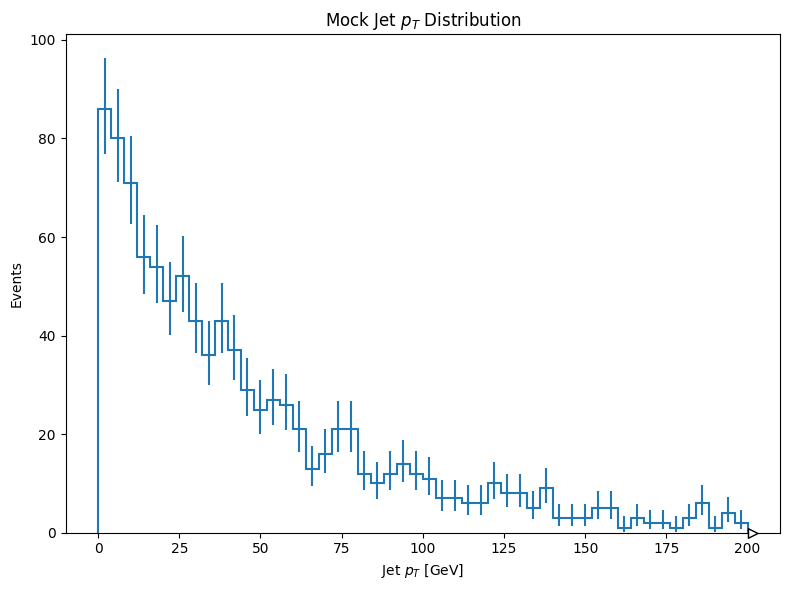

In [44]:
# Modern histogramming with hist
from hist import Hist
import matplotlib.pyplot as plt
import numpy as np

# Create histogram with named axes
np.random.seed(42)
pt_data = np.random.exponential(50, 1000) * np.random.uniform(0.8, 1.2, 1000)

h = Hist.new.Reg(50, 0, 200, name="pt", label="$p_T$ [GeV]").Double()
h.fill(pt=pt_data)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
h.plot1d(ax=ax)
ax.set_xlabel("Jet $p_T$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Mock Jet $p_T$ Distribution")
plt.tight_layout()
plt.savefig("jet_pt_hist.png", dpi=100, bbox_inches='tight')
print("📊 hist: Histogram created and saved!")

print("\n💡 Named axes, units, better plotting. Just better.")

# 5. Industry Tools

## What industry does better (and what we can steal)


### Testing & Linting - It is worth it 

**Industry:** Comprehensive tests, CI/CD, code review, linting 
**HEP:** "It worked on my machine" 

**Tools you should strongly consider using:**

1. **pytest** - Testing framework
2. **black** - Code formatter 
3. **ruff** - Fast linter
4. **Type hinting** - Make sure use cases are clear
5. **pre-commit** - Run checks before committing


In [23]:
# Quick testing example - run simple tests
import pytest

def test_model_output_shape():
    model = SimpleNN()
    x = torch.randn(10, 4)
    output = model(x)
    assert output.shape == (10, 1), "Wrong output shape!"
    return True

def test_model_output_range():
    model = SimpleNN()
    x = torch.randn(10, 4)
    output = model(x)
    assert torch.all(output >= 0) and torch.all(output <= 1), "Sigmoid broken!"
    return True

# Run tests
print("Running tests...")
try:
    test_model_output_shape()
    test_model_output_range()
    print("✅ All tests passed!")
except AssertionError as e:
    print(f"❌ Test failed: {e}")

print("\n💡 Pro tip: Test your preprocessing! That's where most bugs hide.")

Running tests...
✅ All tests passed!

💡 Pro tip: Test your preprocessing! That's where most bugs hide.


### GitHub Actions - Automate Everything

Github actions can automatically run tests, including running automated physics plots! 

Example `.github/workflows/test.yml`:
```yaml
name: Tests
on: [push, pull_request]
jobs:
 test:
 runs-on: ubuntu-latest
 steps:
 - uses: actions/checkout@v3
 - uses: actions/setup-python@v4
 with:
 python-version: '3.10'
 - run: pip install -r requirements.txt
 - run: pytest
 - run: ruff check .
```

### An example use case from jet tagging at L1T - full talk here [https://indico.cern.ch/event/1496673/contributions/6637937/]

<div>
<img src="images/githubaction_example.png" height="400"/>
</div>

### AWS SageMaker - When You Need Industrial Scale

**What it is:** AWS's ML platform (training, deployment, everything)

**Pros:**
- Scales to infinity
- Managed infrastructure
- Production-ready deployment
- AutoML features

**Cons:**
- Costs money (sometimes a lot)
- Learning curve
- Vendor lock-in

**When to use:** 
- You need serious scale
- You have budget
- Production deployment

**HEP alternative:** Usually HTCondor + custom scripts (cheaper, less polished)


### What HEP Can Learn from Industry

| Practice | Industry | HEP | What to do |
|----------|----------|-----|-----------|
| **Testing** | Comprehensive | Sparse | Write pytest tests! |
| **CI/CD** | GitHub Actions | Manual | Add GitHub Actions |
| **Code Review** | Required | Optional | Make PRs mandatory |
| **Documentation** | Detailed | "See code" | Write docstrings |
| **Versioning** | Semantic | Git SHA | Use proper versions |
| **Linting** | Enforced | What's that? | Use ruff/black |

**Bottom line:** Treat your code like a product, not a script.


If you are looking to transition from academia to industry in ML, one of the key things they might want that we don't get much in HEP is AWS and SQL. 

# 6. Fun Shortcuts & "Cheats"

The secret sauce. Ways to make it seem like you've been working hard when you haven't

### 6.1. Make LLMs Do Your Work

**Good uses:**
- Boilerplate code (data loaders, training loops)
- Documentation and docstrings
- Code explanation
- Unit test generation
- Fixing linting errors 

**Bad uses:**
- Can be bad at bug fixing 
- The tests it creates can be meaningless 
- It won't be very useful in knowing how to pre-process your features or choosing model architectures
- It can't to hyperparameter optimization for you  

**Pro tips:**
- Be specific
- **Always understand the code it gives you**


### 6.2. Steal from Hugging Face

**Hugging Face:** GitHub for ML models

**What's there:**
- 500,000+ pre-trained models
- Datasets
- Code examples
- Entire pipelines

**You can:**
- Fine-tune existing models (faster than training from scratch)
- Use pre-trained embeddings
- Copy architectures
- Download datasets



Because of a package conflict I don't run examples here, but check out the [transformers library](https://github.com/huggingface/transformers)

In [ ]:
# Hugging Face Hub: Browse and use models

from huggingface_hub import list_models, hf_hub_download

# List models - no download required, just metadata
print("🔍 Example: Searching for sentiment analysis models")
print("-" * 60)

models = list(list_models(search="sentiment", task="text-classification", limit=3))
for i, model in enumerate(models, 1):
    print(f"{i}. {model.id}")
    print(f"   Downloads: {model.downloads}")

print("\n✅ Browse 500,000+ models without downloading!")
print("💡 Visit: https://huggingface.co/models")



🔍 Example: Searching for sentiment analysis models
------------------------------------------------------------
1. tabularisai/multilingual-sentiment-analysis
   Downloads: 457631
2. lxyuan/distilbert-base-multilingual-cased-sentiments-student
   Downloads: 629858
3. cardiffnlp/twitter-roberta-base-sentiment-latest
   Downloads: 4310462

✅ Browse 500,000+ models without downloading!
💡 Visit: https://huggingface.co/models


### Quick Prototyping Tricks


### 6.3. Prototyping with fastai

In [29]:

# Trick 5: fastai for rapid prototyping

from fastai.tabular.all import *
import pandas as pd

# Create dataset from your features
data = pd.DataFrame(X_train, columns=[f'feature_{j}' for j in range(4)])
data['target'] = y_train

# Use fastai - very simple!
dls = TabularDataLoaders.from_df(data, path='.', y_names='target')
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

learn.fit(5, lr=1e-3)

print('fastai: Prototype in minutes, not hours!')
print('Great for quick experiments and learning')

epoch,train_loss,valid_loss,accuracy,time
0,0.338128,0.326519,0.515000,00:02
1,0.246069,0.212036,0.515000,00:00
2,0.200686,0.135053,0.515000,00:00
3,0.162660,0.087033,0.515000,00:00
4,0.136544,0.072431,0.515000,00:00


fastai: Prototype in minutes, not hours!
Great for quick experiments and learning


In [30]:
# Quick tricks demo

# Trick: torchinfo for model summary
from torchinfo import summary

# Show summary of our PyTorch model
print("Model Summary:")
summary(SimpleNN(), input_size=(32, 4))  # batch_size=32, features=4

# Trick: Use repr to see object details
print("\nModel architecture (repr):")
print(SimpleNN())

# Trick: Quick timing
import time
start = time.time()
# ... your code ...
print(f"Took {time.time() - start:.3f}s")



Model Summary:

Model architecture (repr):
SimpleNN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Took 0.000s


### 6.4. Dataset Shortcuts

**Don't start from scratch:**

1. **Papers with Code** - Find datasets and benchmarks
2. **Kaggle** - Tons of curated datasets
3. **UCI ML Repository** - Classic datasets
4. **HEP Data** - Published HEP datasets
5. **Zenodo** - Open science data


**Pro tip:** Start with a small subset! Debug on 1000 events, not 1M.


### 6.5. The Ultimate Shortcut List

**Good resources:**

 **Learning:**
- fast.ai course (free, excellent)
- PyTorch tutorials (official)
- Papers with Code (implementations)

🛠️ **Tools:**
- GitHub Copilot / Cursor (AI pair programmer)
- Paperswithcode.com (find state-of-the-art)



# Summary: Your ML Toolkit

## Quick Reference Guide

### For Beginners:
1. **Start here:** Scikit-learn for classical ML, Keras for deep learning
2. **Read data:** uproot for ROOT files
3. **Track experiments:** W&B (free for academics!)
4. **Learn:** fast.ai course, official PyTorch tutorials

### For Intermediate Users:
1. **Framework:** PyTorch or PyTorch Lightning
2. **Data:** uproot + awkward array
3. **Optimization:** Optuna
4. **Deployment:** ONNX
5. **Code quality:** pytest, ruff, GitHub Actions

### For Advanced Users:
1. **Speed:** JAX for compute-intensive tasks
2. **Scale:** HTCondor or cloud 
3. **Hardware:** Optimise your GPU usage better
4. **Tools:** Custom pipelines with all the above

### Universal Tips:
- Use version control (git)
- Write tests (pytest)
- Log experiments (W&B/MLflow)
- Document your code
- Start small, scale up
- Leverage pre-trained models (Hugging Face)
- Use LLMs wisely (verify everything!)


# Final Thoughts

## The ML landscape is vast, but you don't need to know everything

**Key takeaways:**

1. **Pick tools that fit YOUR needs** - Don't use fancy tools just because they're fancy
2. **Start simple, add complexity** - Scikit-learn → PyTorch → JAX
3. **Steal shamelessly** - Use pre-trained models, copy good code, ask LLMs
4. **Automate early** - W&B, GitHub Actions, testing save time in the long run
5. **Bridge HEP ↔ ML** - uproot, awkward, hist make life easier
6. **Learn from industry** - Testing, CI/CD, code quality matter
7. **Community is key** - Consider contributing on an opensource ML pacakge

---

## Most important:

### **The best tool is the one you'll actually use.**

Perfect code that doesn't exist < Working code that's "good enough"

---

# Questions? 

Resources:
- These slides: https://github.com/livaage/pyhep-up-your-ml-game
- My contact: liv.helen.vage@cern.ch

**Now go build something cool!** 
